In [4]:
# Load required libraries
library(ISLR)
library(tidyverse)
library(caret)
library(rpart)
library(rpart.plot)
library(boot)
set.seed(123)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma




Preparación de Datos:

Revisamos N.As

In [5]:
# 1. Data Preparation
# Load and clean data
data("Hitters")
hitters_clean <- Hitters %>%
  na.omit() %>%
  mutate(League = as.factor(League),
         Division = as.factor(Division),
         NewLeague = as.factor(NewLeague))

Creamos las variables dummys de las categóricas.

In [6]:
# Create dummy variables
hitters_dummy <- model.matrix(~ . - 1, data = hitters_clean)

Además, realizamos el split [training (90%) y testing (10%)

In [ ]:
# 2. Split the data
n <- nrow(hitters_dummy)
train_idx <- sample(1:n, size = floor(0.9 * n))
X_train <- hitters_dummy[train_idx, -which(colnames(hitters_dummy) == "Salary")]
y_train <- hitters_dummy[train_idx, "Salary"]
X_test <- hitters_dummy[-train_idx, -which(colnames(hitters_dummy) == "Salary")]
y_test <- hitters_dummy[-train_idx, "Salary"]

In [12]:
# 3. OLS Regression and Bootstrap
# Initial OLS fit
train_data <- data.frame(Salary = y_train, X_train)
ols_model <- lm(Salary ~ ., data = train_data)
beta_hat <- coef(ols_model)

# Modified bootstrap function with error handling
bootstrap_ols <- function(data, indices) {
  tryCatch({
    sample_data <- data[indices, ]
    model <- lm(Salary ~ ., data = sample_data)
    return(coef(model))
  }, error = function(e) {
    return(rep(NA, length(beta_hat)))
  })
}


In [13]:
# Perform bootstrap
n_boot <- 10000
boot_results <- boot(data = train_data,
                    statistic = bootstrap_ols,
                    R = n_boot)

In [14]:
# Calculate confidence intervals with NA handling
beta_boots <- t(sapply(1:n_boot, function(i) boot_results$t[i,]))

In [15]:
# Function to calculate quantiles with NA handling
safe_quantile <- function(x, probs) {
  quantile(x, probs = probs, na.rm = TRUE)
}


In [16]:
# Calculate confidence intervals
beta_boots_lower <- apply(beta_boots, 2, function(x) safe_quantile(x, 0.025))
beta_boots_upper <- apply(beta_boots, 2, function(x) safe_quantile(x, 0.975))

In [17]:
# Calculate OLS out-of-sample MSE
ols_predictions <- predict(ols_model, newdata = data.frame(X_test))
ols_mse <- mean((y_test - ols_predictions)^2)

In [18]:
# 4. Regression Tree
# Fit full tree
tree_model <- rpart(Salary ~ .,
                   data = train_data,
                   method = "anova",
                   control = rpart.control(minsplit = 2, cp = 0))

In [19]:
# Cross-validate to find optimal cp
cpTable <- printcp(tree_model)
optimal_cp <- cpTable[which.min(cpTable[,"xerror"]), "CP"]



Regression tree:
rpart(formula = Salary ~ ., data = train_data, method = "anova", 
    control = rpart.control(minsplit = 2, cp = 0))

Variables actually used in tree construction:
 [1] Assists    AtBat      CAtBat     CHits      CHmRun     CRBI      
 [7] CRuns      CWalks     DivisionW  Errors     Hits       HmRun     
[13] LeagueA    NewLeagueN PutOuts    RBI        Runs       Walks     
[19] Years     

Root node error: 49071704/236 = 207931

n= 236 

            CP nsplit  rel error  xerror    xstd
1   3.8835e-01      0 1.0000e+00 1.01439 0.14787
2   1.5330e-01      1 6.1165e-01 0.63003 0.12393
3   7.4640e-02      2 4.5835e-01 0.50708 0.10814
4   5.2206e-02      3 3.8371e-01 0.58348 0.11666
5   4.1054e-02      4 3.3150e-01 0.60729 0.11818
6   3.3081e-02      5 2.9045e-01 0.62457 0.12030
7   3.0969e-02      6 2.5737e-01 0.63076 0.12045
8   2.3431e-02      7 2.2640e-01 0.62432 0.12089
9   1.7296e-02      8 2.0297e-01 0.63225 0.12440
10  1.3205e-02      9 1.8567e-01 0.62975 0.12870


In [21]:

# Prune tree
pruned_tree <- prune(tree_model, cp = optimal_cp)

# Calculate tree out-of-sample MSE
tree_predictions <- predict(pruned_tree,
                          newdata = data.frame(X_test))
tree_mse <- mean((y_test - tree_predictions)^2)

In [22]:
# 5. Results
cat("\nModel Performance Comparison:")
cat("\n-------------------------")
cat("\nOLS Out-of-Sample MSE:", round(ols_mse, 2))
cat("\nTree Out-of-Sample MSE:", round(tree_mse, 2))
cat("\n\nBest performing model:",
    ifelse(ols_mse < tree_mse, "OLS Regression", "Regression Tree"))


Model Performance Comparison:
-------------------------
OLS Out-of-Sample MSE: 205028.4
Tree Out-of-Sample MSE: 176619.1

Best performing model: Regression Tree

In [23]:
# Print confidence intervals for OLS coefficients
ci_table <- data.frame(
  Coefficient = names(beta_hat),
  Estimate = round(beta_hat, 4),
  Lower_CI = round(beta_boots_lower, 4),
  Upper_CI = round(beta_boots_upper, 4)
)
print("\nOLS Coefficient Estimates and 95% Confidence Intervals:")
print(ci_table)



[1] "\nOLS Coefficient Estimates and 95% Confidence Intervals:"
            Coefficient  Estimate  Lower_CI Upper_CI
(Intercept) (Intercept)  195.7404  -63.8590 508.9423
AtBat             AtBat   -1.6186   -3.2370   0.0137
Hits               Hits    5.1974   -1.0708  11.1677
HmRun             HmRun   -0.9441  -13.2088  12.0465
Runs               Runs   -1.2292   -7.9399   5.5174
RBI                 RBI    0.1647   -5.3647   5.7422
Walks             Walks    6.4475    2.1877  10.3037
Years             Years  -11.8179  -38.5881  14.0835
CAtBat           CAtBat   -0.2542   -0.6579   0.1648
CHits             CHits    0.6910   -1.0520   2.4616
CHmRun           CHmRun    1.2268   -2.6233   5.7945
CRuns             CRuns    1.1571   -0.6337   2.9705
CRBI               CRBI    0.4689   -1.3651   2.0403
CWalks           CWalks   -0.7005   -1.5151   0.1446
LeagueA         LeagueA  -25.5772 -151.9728  95.4706
LeagueN         LeagueN        NA        NA       NA
DivisionW     DivisionW -102.3984 -

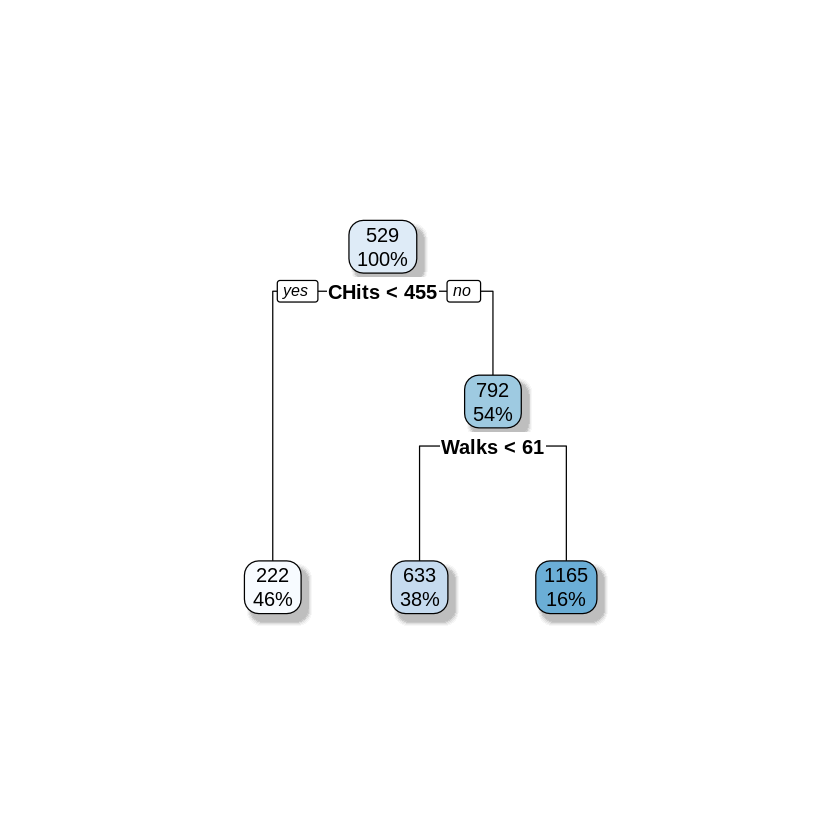

In [24]:
# Plot the pruned tree
par(mar = c(1,1,1,1))
rpart.plot(pruned_tree,
           box.palette = "Blues",
           shadow.col = "gray",
           fallen.leaves = TRUE)